In [1]:
import os
import sys
import importlib
import pickle
import emcee
import corner
AbsPath = str(os.path.abspath(""))+"/../.."
sys.path.append(AbsPath)
from itertools import cycle
import scipy.stats
import matplotlib.pyplot as plt
from Functions import Functions as F
from numba import jit
HMF_fun = F.Make_HMF_Interp()
from Functions.Functions import Make_HMF_Interp
import numpy as np
import matplotlib.pyplot as plt
import colossus.halo.mass_adv as massdefs
from colossus.cosmology import cosmology
from scipy.interpolate import interp1d
cosmology.setCosmology("planck15")
Cosmo =cosmology.getCurrent()

h = Cosmo.h


In [2]:
#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}



#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

In [29]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T

#Load STEEL style haloes
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
z_arr, halo_masses_sat, number_densitys_sat = F.LoadData_MultiEpoch_SubHalos(Fit)
halo_masses_cen = AvaHaloMass[Data_z_ix]
number_densitys_cen = HMF_fun(halo_masses_cen, 0.5)
#Brute force the gamma sigma space returning a weighting describing the 'goodness of fit' between HOD and the toy model

#Central only toy model
Override['M10'] = 12.0
Override['SHMnorm10'] = 0.032
Override['beta10'] = 1.5
Override['gamma10'] = 0.58
Override['M11'] = 0
Override['SHMnorm11'] = 0
Override['beta11'] = 0
Override['gamma11'] = 0.0

@jit
def make_dist(gamma_in, sigma_in, cen_sat = 'cen'):
    """
    #Function to compute the distribution for a given gamma sigma pair
    #Inputs:
    #    gamma_in: high mass slope of the SMHM relation
    #    sigma_in: scatter of the SMHM relation
    #Returns:
    #    [X_cen, Y_cen]: the X and Y values for the distribution
    """
    Override['gamma10'] = gamma_in
    if cen_sat == 'cen':
        halo_masses, number_densitys = halo_masses_cen, number_densitys_cen
    elif cen_sat == 'sat':
        halo_masses, number_densitys_z = halo_masses_sat, number_densitys_sat
        z_bin = np.digitize(0.5, bins = z_arr)
        number_densitys = np.sum(number_densitys_z[z_bin], axis = 0)
    AbnMtch['Override_z'] = True    
    stellar_mass = F.DarkMatterToStellarMass(halo_masses-np.log10(h), 0.5, Paramaters, ScatterOn = False)
    AbnMtch['Override_z'] = False
    norm = scipy.stats.norm(stellar_mass, sigma_in)
    prob = 1-norm.cdf(11.45)
    weights = number_densitys*prob
    X, Y = F.Gauss_Scatt(halo_masses, weights, Scatt = 0.1)
    if cen_sat == 'cen':
        Y = Y*(10**4)
    elif cen_sat == 'sat':
        Y = Y*(10**4)
    return [X, Y]

@jit
def compare_dist(hod, toy, cen_sat = 'cen'):
    """
    #Function to compare two distributions and return a least suares value
    #Inputs:
    #    hod: the HOD model distribution 2d distribution [2,N]
    #    toy: the toy model distribution 2d distribution [2,N]
    #Outputs:
    #    least_sq: the least squares value when comparing the two data
    """
    
    #first interpolate over both data sets
    if cen_sat == 'cen':
        hod_interp = interp1d(hod[0], hod[1])
    elif cen_sat == 'sat':
        hod_interp = interp1d(hod[0], hod[2]/10)
    toy_interp = interp1d(toy[0], toy[1])
    
    #choose x values to sample, 100 values over tthe range 12.5 to 15
    x_sample = np.linspace(12.5, 15, num = 100)
    
    #calculate the average square of the distance between the two curves
    least_sq = np.sum(np.power(hod_interp(x_sample) - toy_interp(x_sample),2))/100
    
    return least_sq

def vec_func(values_in, hod, cen_sat = 'cen'):
    gamma_in, sigma_in, = values_in
    toy_dist = make_dist(gamma_in, sigma_in, cen_sat = cen_sat)
    return compare_dist(hod, toy_dist, cen_sat = cen_sat)

def find_areas(norm_area):
    """
    #This function takes in a normilised area and returns the levels to plot 
    #1,2,&3 sigma confidence intervals corresponding to the 68-95-99.7 rule
    #This function sweeps from highest value down and sums each data point
    #until a threshold is met.
    #Input:
    #    norm_area: A normilised 2d array
    #Output:
    #    levels: The 68-98-9.7 levels
    #    per_enc: percentages enclosed
    """
    per_enc = [0.997,0.95,0.68, 0.2]
    #Flatten and order the array from lagest to smallest
    flatten = lambda l: [item for sublist in l for item in sublist]
    flat_norm_area = flatten(norm_area)
    flat_norm_area.sort() #sorts array from smallest to lartgest
    flat_norm_area = flat_norm_area[::-1] #array flipped to be largest to smallest
    #find the indexes at which the cumulative sum of the array meets the threshold.
    indexes = np.digitize(per_enc, bins = np.cumsum(flat_norm_area))
    levels = [round(flat_norm_area[i-1], 6) for i in indexes]
    return levels, per_enc

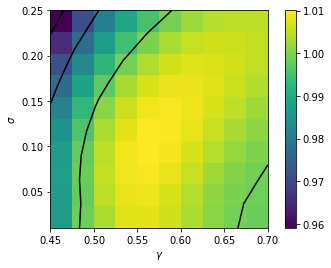

Least Squares =  0.004132236536962829 at gamma, sigma =  [0.5611111111111111, 0.08999999999999998]


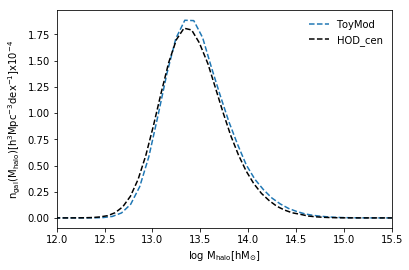

In [6]:
gamma_min=0.45
gamma_max=0.7
sigma_min=0.01
sigma_max=0.25
gamma_samples=10
sigma_samples=10
gamma_range=np.linspace(gamma_min, gamma_max, num = gamma_samples)
sigma_range=np.linspace(sigma_min, sigma_max, num = sigma_samples)
values = [[[gamma_ix,sigma_ix] for sigma_ix in sigma_range] for gamma_ix in gamma_range]

least_sq = [[vec_func(values_in, Tkr_hod) for values_in in values_subarr] for values_subarr in values]

#normalise to make a heatmap
least_sq_norm_cen = (np.sum(least_sq) - np.array(least_sq))/np.sum(np.sum(least_sq) - np.array(least_sq))

#plot heatmap of the fit, np.power here is used to excentuate the maximum set to 1 for true normilisation

even_wt = 1/(gamma_samples*sigma_samples)

fig = plt.imshow(least_sq_norm_cen.T/even_wt, cmap=plt.cm.viridis, origin =  'lower', extent=[gamma_min, gamma_max,sigma_min, sigma_max], aspect = ((gamma_min-gamma_max)/(sigma_min-sigma_max)))
fig.fig_size = (5, 5)
plt.colorbar()
plt.contour(gamma_range, sigma_range, least_sq_norm_cen.T, levels = find_areas(least_sq_norm_cen.T), colors = 'k')
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\sigma$")

plt.show()

#lambda function to flatten the 2d lists
flatten = lambda l: [item for sublist in l for item in sublist]
#flattending the lists
flat_sq = flatten(least_sq); flat_value = flatten(values)
#extract best fit pair
min_value = min(flat_sq)
best_fit = flat_value[flat_sq.index(min_value)]
print("Least Squares = ", min_value, "at gamma, sigma = ", best_fit)

#get and plot best fit
x, y = make_dist(best_fit[0], best_fit[1])
plt.plot(x, y, "--",label ="ToyMod")
plt.plot(Tkr_hod[0], Tkr_hod[1], "--",label = "HOD_cen", color = "k")
plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()

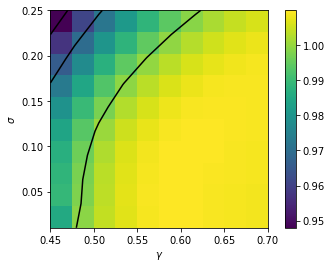

Least Squares =  0.0008257736451354915 at gamma, sigma =  [0.6166666666666667, 0.08999999999999998]


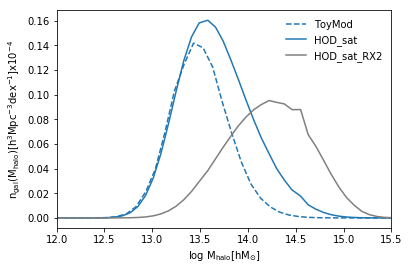

In [7]:
gamma_min=0.45
gamma_max=0.7
sigma_min=0.01
sigma_max=0.25
gamma_samples=10
sigma_samples=10
gamma_range=np.linspace(gamma_min, gamma_max, num = gamma_samples)
sigma_range=np.linspace(sigma_min, sigma_max, num = sigma_samples)
values = [[[gamma_ix,sigma_ix] for sigma_ix in sigma_range] for gamma_ix in gamma_range]

even_wt = 1/(gamma_samples*sigma_samples)

least_sq_sat = [[vec_func(values_in, Tkr_hod, cen_sat = 'sat') for values_in in values_subarr] for values_subarr in values]
#normalise to make a heatmap
least_sq_norm_sat = (np.sum(least_sq_sat) - np.array(least_sq_sat))/np.sum(np.sum(least_sq_sat) - np.array(least_sq_sat))

#plot heatmap of the fit, np.power here is used to excentuate the maximum set to 1 for true normilisation
fig = plt.imshow(least_sq_norm_sat.T/even_wt, cmap=plt.cm.viridis, origin = 'lower', extent=[gamma_min, gamma_max,sigma_min, sigma_max], aspect = ((gamma_min-gamma_max)/(sigma_min-sigma_max)))
fig.fig_size = (5, 5)
plt.colorbar()
plt.contour(gamma_range, sigma_range, least_sq_norm_sat.T, levels = find_areas(least_sq_norm_sat.T), colors = 'k')
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\sigma$")
plt.show()

#lambda function to flatten the 2d lists
flatten = lambda l: [item for sublist in l for item in sublist]
#flattending the lists
flat_sq_sat = flatten(least_sq_sat); flat_value = flatten(values)
#extract best fit pair
min_value_sat = min(flat_sq_sat)
best_fit_sat = flat_value[flat_sq_sat.index(min_value_sat)]
print("Least Squares = ", min_value_sat, "at gamma, sigma = ", best_fit_sat)

#get and plot best fit
x, y = make_dist(best_fit_sat[0], best_fit_sat[1], cen_sat = "sat")
plt.plot(x, y, "--",label ="ToyMod")

#HOD
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, "-",label = "HOD_sat", color = "C0")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), "-",label = "HOD_sat_RX2", color = "C7")

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()

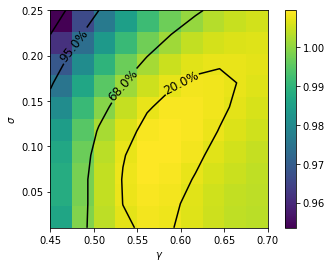

In [37]:
area_levels, per_enclosed = find_areas(least_sq_norm_total.T)
fig = plt.imshow(least_sq_norm_total.T/even_wt, cmap=plt.cm.viridis, origin = 'lower', extent=[gamma_min, gamma_max,sigma_min, sigma_max], aspect = ((gamma_min-gamma_max)/(sigma_min-sigma_max)))
fig.fig_size = (5, 5)
plt.colorbar()
area_levels, per_enclosed = find_areas(least_sq_norm_total.T)
c = plt.contour(gamma_range, sigma_range, least_sq_norm_total.T, levels = area_levels, colors = 'k')
contour_labels = {}
for i, lvl in enumerate(area_levels):
    contour_labels[lvl] = str(per_enclosed[i]*100)+'%'
plt.clabel(c, fontsize = 12, inline = 1, fmt = contour_labels)
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\sigma$")
plt.show()